In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [4]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

In [5]:
sns.set()

## Data Prep

### Read Synergy Data

In [6]:
s_df = pd.read_csv('nba_offense.csv')
s_df['Player'] = s_df['Player'].apply(lambda x: ' '.join(x.split(' ')[1:]))
s_df.shape

(2973, 74)

Include labels regarding half court offense only

In [7]:
s_df['Overall_Poss'] = s_df['Overall_Poss'] - s_df['Miscellaneous_Poss'] - s_df['Transition_Poss']

In [8]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 
#                      'Transition_Poss%', 
                     'Hand Off_Poss%', 'Off Screen_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 
                     'Post-Up_Poss%']

In [9]:
for col in poss_weights_cols:
    s_df[col] = s_df[col.replace('%', '')] / s_df['Overall_Poss']
    s_df[col] = s_df[col].fillna(0)

### Read BBR Data

In [10]:
bbr_adv_df = pd.read_csv('bbr_nba_advanced_stats.csv')
bbr_adv_df.shape

(2986, 28)

In [11]:
bbr_ros_df = pd.read_csv('bbr_nba_roster_stats.csv')
bbr_ros_df.shape

(2988, 12)

In [12]:
bbr_df = bbr_adv_df.merge(bbr_ros_df, how='left',
                          on=['player', 'season', 'team', 'player_alt'])
bbr_df.shape

(2986, 36)

Convert heights

In [13]:
def convert_height(height):
    feet, inches = height.split('-')
    cm = int(feet) * 12 + int(inches)
    return round(cm * 2.54, 1)

In [14]:
bbr_df['height_cm'] = bbr_df['height'].apply(convert_height)

Convert weights

In [15]:
bbr_df['weight_kg'] = bbr_df['weight'].apply(lambda x: round(0.453592 * x, 1))

Filter in players with 250 shot possessions

In [16]:
s_df = s_df[s_df['Overall_Poss'] >= 250]
s_df.shape

(1422, 74)

Filter in players that played over 200 minutes

In [17]:
bbr_df = bbr_df[bbr_df['mp'] >= 200]
bbr_df.shape

(2268, 38)

### Merge Synergy Data & BBR Data

In [18]:
s_df['Player_Alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))

In [19]:
bbr_df['player_alt_alt'] = bbr_df['player_alt'].apply(lambda x: x.replace(' ', ''))\
                                               .apply(lambda x: x.replace("'", ''))\
                                               .apply(lambda x: x.replace('.', ''))\
                                               .apply(lambda x: x.lower())

In [20]:
synergy_name_dict = {'kevinknoxii': 'kevinknox',
                     'danilogalinari': 'danilogallinari',
                     'louiswilliams': 'louwilliams',
                     'eneskanter': 'enesfreedom',
                     'terryrozieriii': 'terryrozier',
                     'cameronreddish': 'camreddish',
                     'jahilokafor': 'jahlilokafor',
                     'danuelhouse': 'danuelhousejr',
                     'alfarouqaminu': 'al-farouqaminu',
                     'nenehilario': 'nene',
                     'frankmason': 'frankmasoniii',
                     'larrynance': 'larrynancejr',
                     'wesleyiwundu': 'wesiwundu',
                     'robertwilliamsiii': 'robertwilliams',
                     'harrygilesiii': 'harrygiles',
                     'jamesennis': 'jamesennisiii',
                     'mohamedbamba': 'mobamba',
                     'xaviertillman': 'xaviertillmansr',
                     'patrickbeverly': 'patrickbeverley',
                     'malcomdelaney': 'malcolmdelaney',
                     'marcusmorrissr': 'marcusmorris',
                     'nicolasclaxton': 'nicclaxton',
                     'juanhernangomez': 'juanchohernangomez',
                     'guillermohernangomez': 'willyhernangomez',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot'}
s_df['Player_Alt'] = s_df['Player_Alt'].apply(lambda x: synergy_name_dict[x] 
                                              if x in synergy_name_dict.keys()
                                              else x)

In [21]:
df = s_df.merge(bbr_df, how='left', 
                left_on=['Player_Alt', 'Team', 'Season'],
                right_on=['player_alt_alt', 'team', 'season'])
df = df[~df['player_alt_alt'].isna()].reset_index().drop('index', axis=1)
df.shape

(1421, 114)

In [22]:
# check 
df[['Player_Alt', 'Team', 'Season']].drop_duplicates().shape

(1421, 3)

## Functions

In [23]:
poss_ppp_cols = ['Spot Up_PPP', 'P&R Ball Handler_PPP', 
#                  'Transition_PPP',
                 'Cut_PPP', 'Hand Off_PPP', 'Offensive Rebounds (put backs)_PPP',
                 'P&R Roll Man_PPP', 'Isolation_PPP', 'Off Screen_PPP',
                 'Post-Up_PPP']

In [24]:
def find_optimal_k(x):
    avg_ss_list = []
    k_list = list(range(2, 11))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                eigen_solver="arpack",
                                affinity="nearest_neighbors")
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)
        
    top_ss = np.max(avg_ss_list)
    for i in range(len(k_list)):
        if avg_ss_list[i] == top_ss:
            return k_list[i]

In [25]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method showing the optimal k')

In [26]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 8))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.9, 2, 7, color='red', linestyle='--')
    plt.xlabel('c')
    plt.ylabel('Explained Variance Ratio')

In [27]:
def get_playtype_dist(df, poss_ppp_cols=poss_ppp_cols):
    playtype_dfs = []
    for col in poss_ppp_cols:
        playtype = col.replace('_PPP', '')
        playtype_df = pd.DataFrame()
        playtype_df['PPP'] = df[col]
        playtype_df['Poss%'] = df[f'{playtype}_Poss%'] * 100
        playtype_df['playtype'] = playtype
        playtype_dfs.append(playtype_df)   
    return pd.concat(playtype_dfs)

In [28]:
def show_cluster_res(df, cluster_col, poss_weights_cols=poss_weights_cols):
    cluster_res = df.groupby(cluster_col)[['usg_pct', 'obpm'] + poss_weights_cols]\
                .mean().sort_values('obpm', ascending=False)
    cluster_cnt = Counter(df[cluster_col])
    cluster_res['obpm'] = cluster_res['obpm'].apply(lambda x: f'{x:.2f}')
    cluster_res['usg_pct'] = cluster_res['usg_pct'].apply(lambda x: f'{x:.1f}%')
    for col in cluster_res.columns:
        if '%' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

In [29]:
def plot_cluster_res_2d(df, cluster_col, col1, col2):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, label=f'Cluster {cluster}', alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [30]:
def check_cluster_robustness(x, k, n_iters):
    cluster_res = []
    for i in range(n_iters):
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
        pred = sc.fit(x).labels_
        res = sorted([list(pred).count(cluster) for cluster in list(range(k))])
        cluster_res.append('-'.join([str(n) for n in res]))
    return Counter(cluster_res)

In [31]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'obpm']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('obpm', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('obpm')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

## Clustering

Show correlations among playtype possession%

<AxesSubplot:>

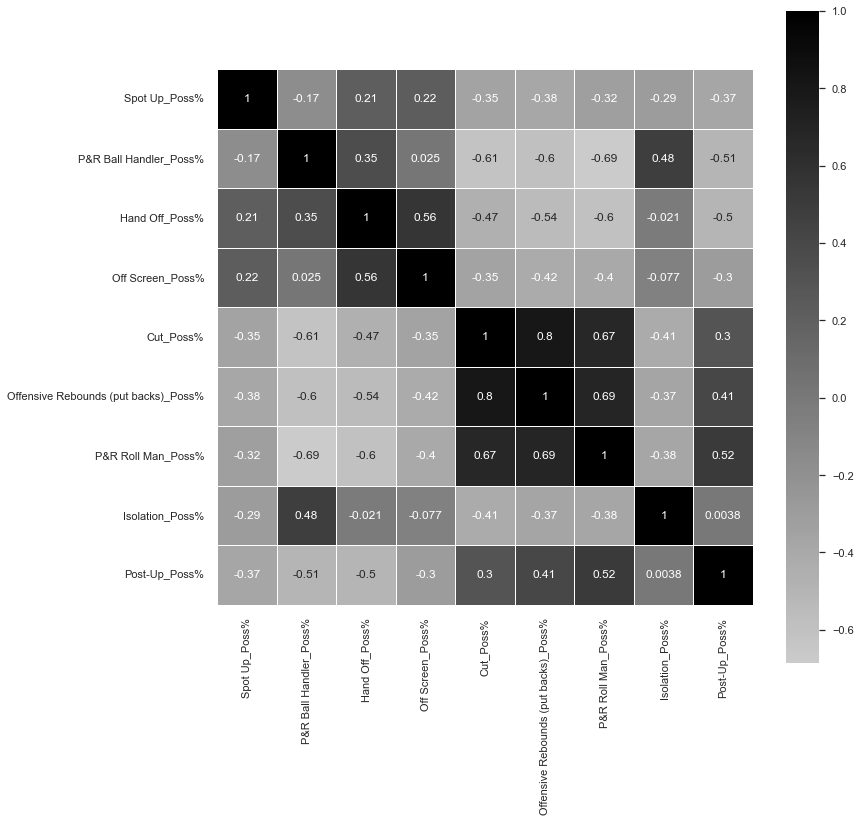

In [32]:
figsize(12, 8)
corr = df[poss_weights_cols].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5)

Show distributions of possession weights and effeiciency of each playtype

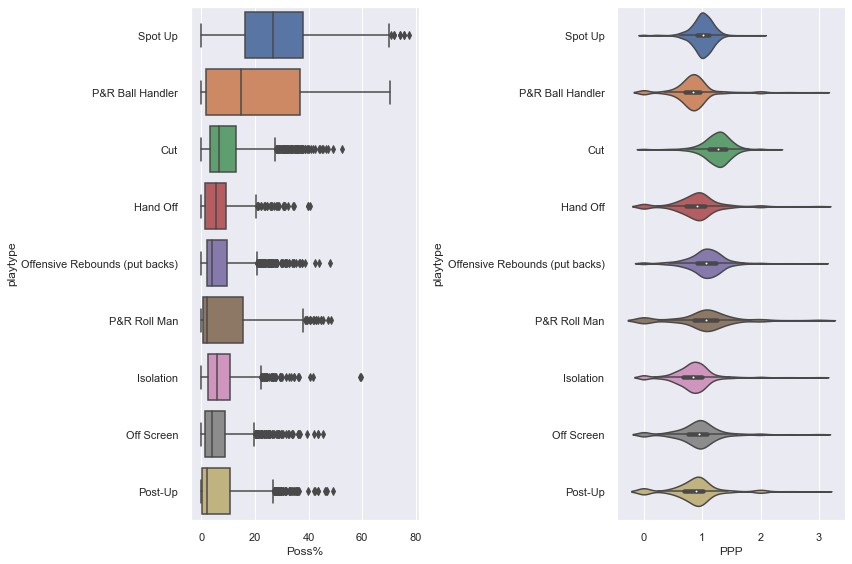

In [33]:
figsize(12, 8)
data = get_playtype_dist(df)
plt.subplot(1, 2, 1)
sns.boxplot(x="Poss%", y="playtype", data=data)
plt.subplot(1, 2, 2)
sns.violinplot(x="PPP", y="playtype", data=data)
plt.tight_layout()

Summary of distribution in playtype weights:
- Outliers exist 
    - Most of them are the result of skewed data
    - A few of them are creditted to players' own unique tendencies (ex. James Harden's iso game)
- There are some common playtypes
    - Spot Up
    - Transition
- Most are skewed
    - Big man
        - Cut
        - Offensive Rebounds
        - P&R Roll Man
        - Post-Up
    - Perimeter players
        - P&R Ball Handler
        - Hand Off
        - Off Screen
    - Star Privilege
        - Post-Up
        - Isolation
    
        

### Clustering

In [35]:
X = df[poss_weights_cols].copy()

Determine how many components reduce down to via PCA

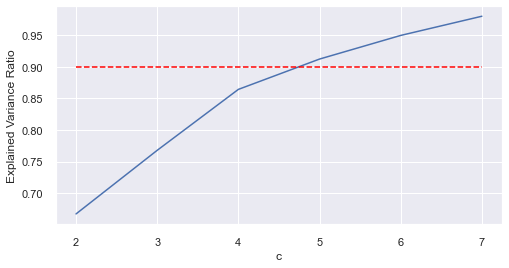

In [36]:
figsize(8, 4)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choose 6

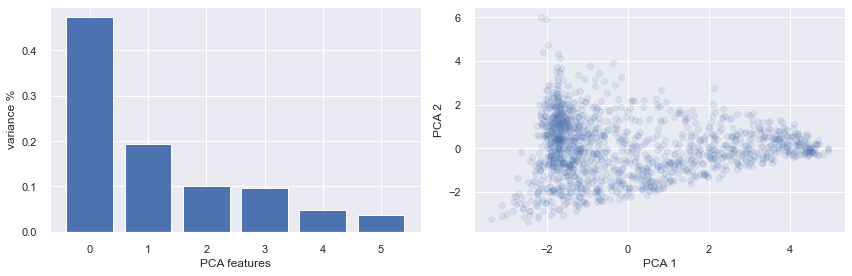

In [37]:
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=6)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 4)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [38]:
X_transformed = StandardScaler().fit_transform(pca_components)

Determine # of clusters using silhouette score method

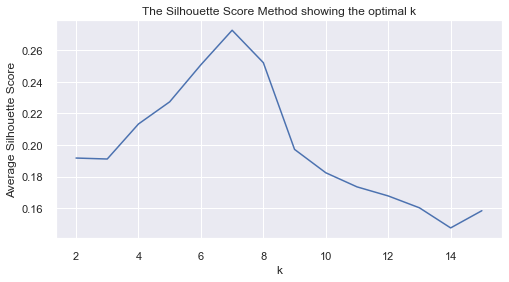

In [39]:
figsize(8, 4)
plot_silhouette_score(X_transformed)

Try 500 times to see if the clustering result stays robust. It turns out the algorithm delivers the same result 

In [40]:
# Check stability
check_cluster_robustness(X_transformed, 7, 500)

Counter({'47-113-143-150-212-333-423': 17,
         '47-118-140-150-216-331-419': 23,
         '48-128-143-149-212-330-411': 153,
         '48-112-142-145-211-335-428': 7,
         '48-118-138-149-213-336-419': 2,
         '47-118-143-150-211-333-419': 10,
         '47-112-142-149-211-335-425': 1,
         '47-118-142-150-211-334-419': 23,
         '48-118-143-149-212-332-419': 9,
         '47-128-143-150-212-330-411': 9,
         '48-112-143-144-211-334-429': 1,
         '48-118-142-149-211-334-419': 29,
         '48-128-142-149-212-331-411': 18,
         '47-115-140-150-216-332-421': 4,
         '47-118-143-150-212-332-419': 36,
         '48-115-138-149-213-337-421': 1,
         '47-115-142-150-211-335-421': 11,
         '48-112-138-145-214-335-429': 1,
         '48-112-140-144-216-332-429': 2,
         '48-115-142-149-211-335-421': 8,
         '47-115-143-150-211-334-421': 5,
         '48-112-143-144-212-333-429': 1,
         '47-115-143-150-212-333-421': 3,
         '48-112-139-144

### Results

In [41]:
# Choose k = 7
sc = SpectralClustering(n_clusters=7, affinity='nearest_neighbors', random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    411
1    149
2    143
3    128
4    330
5    212
6     48
Name: Player, dtype: int64

#### OBPM & Usage by Cluster

In [42]:
show_cluster_res(df, 'player_cluster')

,0,1,2,3,4,5,6
player_cluster,3,5,1,0,2,6,4
usg_pct,25.8%,22.8%,21.1%,21.9%,16.5%,17.8%,16.6%
obpm,2.07,1.05,0.56,0.07,-0.06,-0.55,-0.98
Spot Up_Poss%,19.05%,19.58%,30.42%,25.11%,8.36%,34.43%,46.42%
P&R Ball Handler_Poss%,27.91%,2.13%,21.01%,44.52%,0.44%,16.52%,8.42%
Hand Off_Poss%,4.92%,1.35%,10.12%,8.45%,0.29%,23.93%,5.28%
Off Screen_Poss%,4.70%,2.83%,20.67%,4.91%,0.37%,13.39%,5.48%
Cut_Poss%,5.42%,12.67%,5.55%,3.64%,30.19%,5.73%,10.26%
Offensive Rebounds (put backs)_Poss%,3.71%,11.00%,2.56%,2.40%,21.88%,2.05%,7.19%
P&R Roll Man_Poss%,3.05%,21.59%,1.24%,0.63%,27.84%,1.35%,7.96%


- Ballhandler: 3 & 0
- Big: 5 & 2
- Wing: 1 & 6 & 4

#### Possession Weights by Cluster

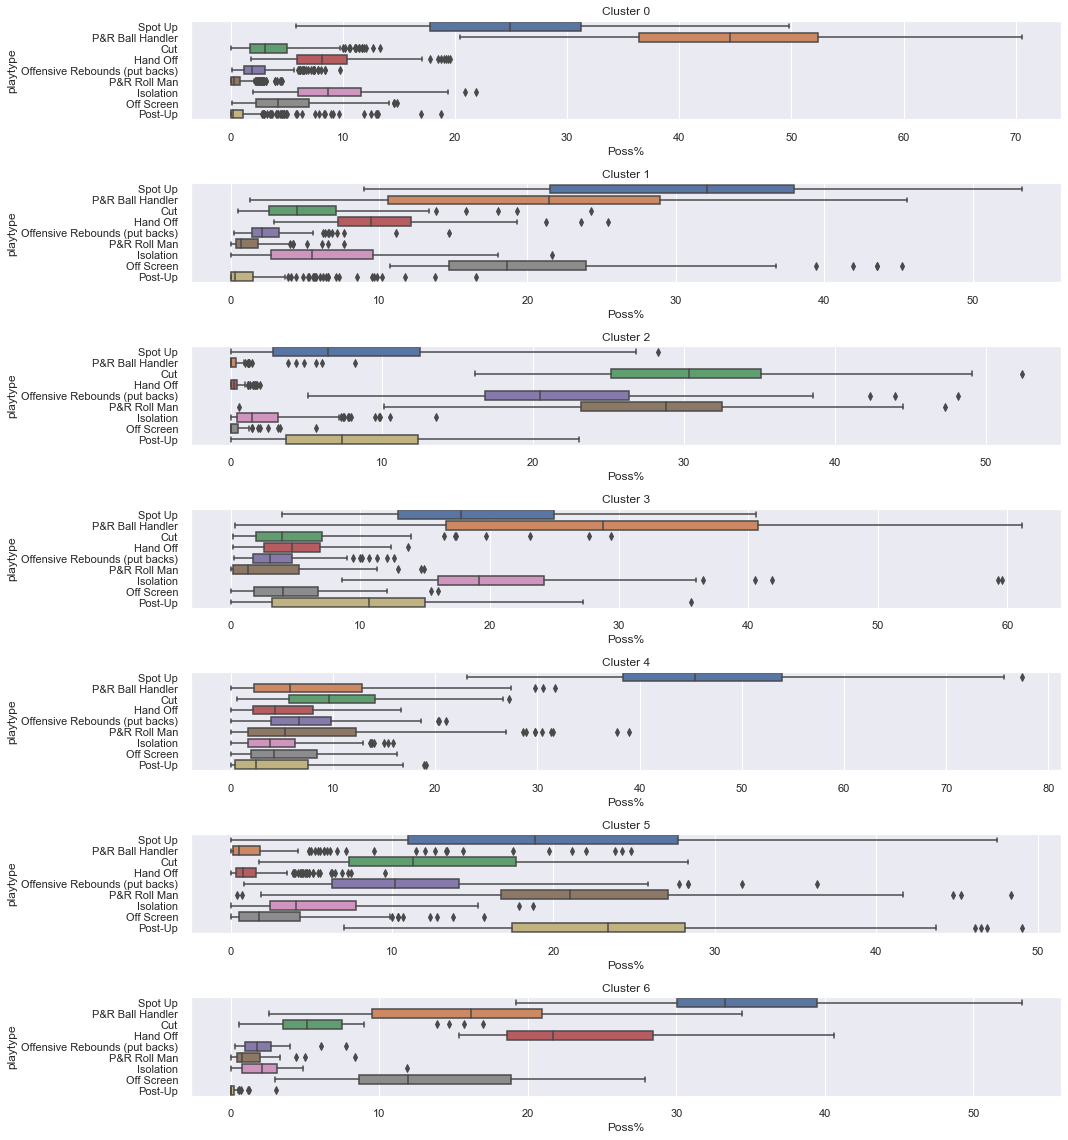

In [52]:
figsize(15, 16)
n_clusters = len(set(df['player_cluster']))
data_dict = {cluster: get_playtype_dist(df[df['player_cluster'] == cluster])
             for cluster in range(n_clusters)}

for cluster in range(n_clusters):
    data = get_playtype_dist(df[df['player_cluster'] == cluster])
    plt.subplot(n_clusters, 1, cluster+1)
    sns.boxplot(x="Poss%", y="playtype", data=data_dict[cluster])
    plt.title(f'Cluster {cluster}')

plt.tight_layout()

Summary of distribution in playtype weights:
- Good:
    - Cluster separate playtypes regarding pick & roll nicely
    - Cluster separate iso & post-up nicely
- Bad:
    - Skewed data & Outliers still exist

#### Observations

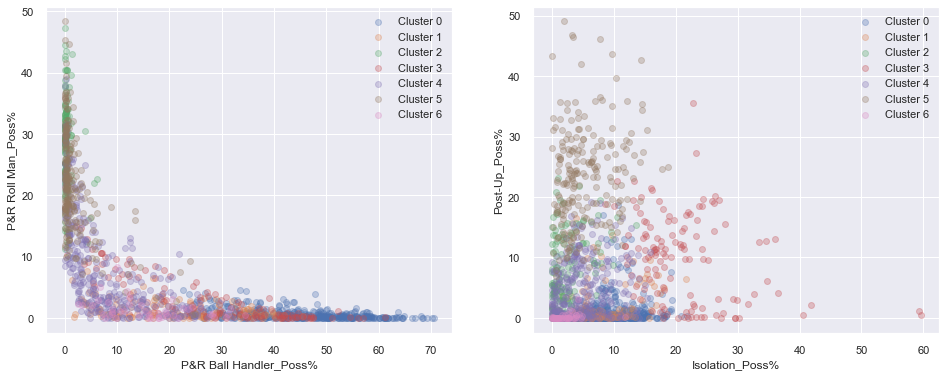

In [43]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='P&R Roll Man_Poss%')
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='Isolation_Poss%', 
                    col2='Post-Up_Poss%')

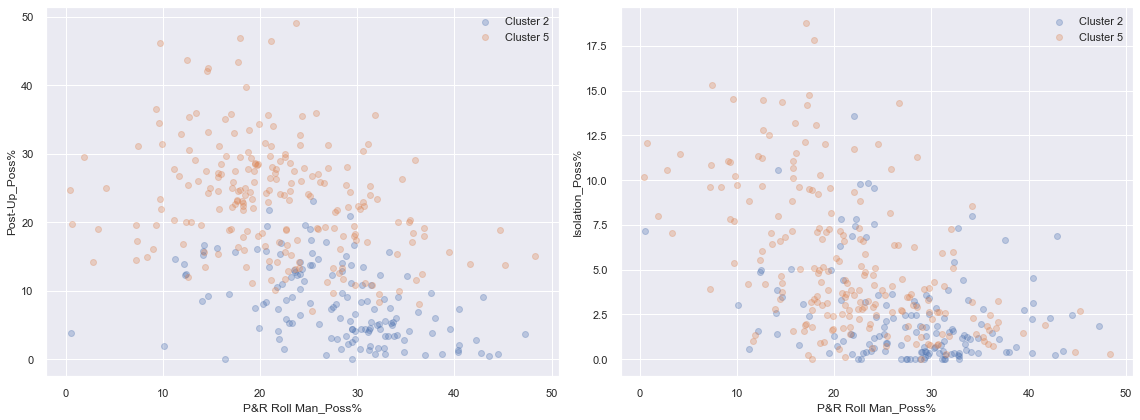

In [44]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([5, 2])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%')
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([5, 2])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%')
plt.tight_layout()

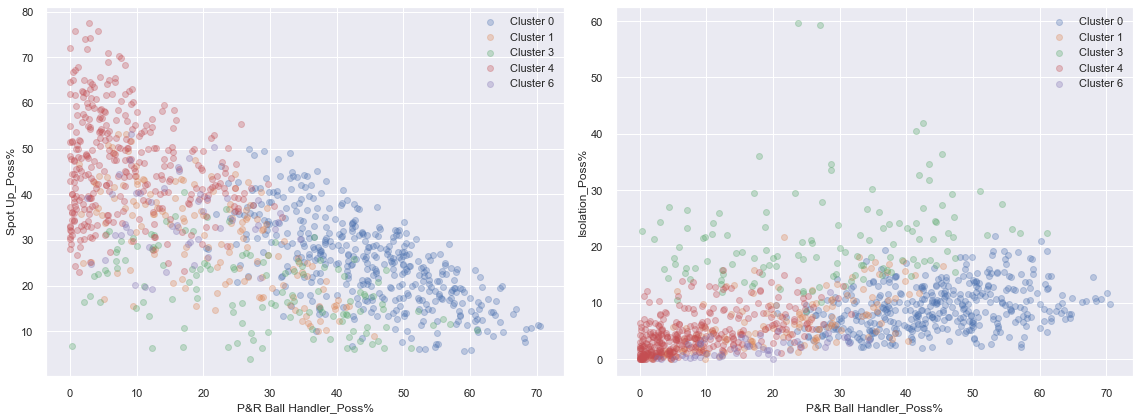

In [45]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([0, 1, 3, 4, 6])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%')
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([0, 1, 3, 4, 6])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%')
plt.tight_layout()

#### Top & Bottom Players by Cluster

##### Ballhandlers

In [46]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 128


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,James Harden,2018,Houston Rockets,9.4,Kevin Porter Jr.,2019,Cleveland Cavaliers,-3.2
1,Russell Westbrook,2016,Oklahoma City Thunder,8.7,RodneyStuckey,2016,Indiana Pacers,-3.2
2,James Harden,2017,Houston Rockets,8.5,Brandon Ingram,2016,Los Angeles Lakers,-3.0
3,James Harden,2019,Houston Rockets,8.1,Shaun Livingston,2016,Golden State Warriors,-3.0
4,James Harden,2016,Houston Rockets,7.5,Austin Rivers,2018,Houston Rockets,-2.9
5,Giannis Antetokounmpo,2019,Milwaukee Bucks,7.4,Shaun Livingston,2017,Golden State Warriors,-2.8
6,LeBron James,2017,Cleveland Cavaliers,7.3,Evan Turner,2016,Portland Trail Blazers,-2.3
7,Kawhi Leonard,2016,San Antonio Spurs,7.1,Dion Waiters,2017,Miami Heat,-2.1
8,Kevin Durant,2017,Golden State Warriors,6.7,Austin Rivers,2019,Houston Rockets,-2.1
9,LeBron James,2019,Los Angeles Lakers,6.6,Jahil Okafor,2016,Philadelphia 76ers,-1.9


In [47]:
# df[df['player_cluster'] == 3].groupby('Player')['Season']\
#                              .count().reset_index().sort_values('Season', ascending=False)

In [48]:
# for col in df.columns:
#     if 'Poss%' in col:
#         print(col, df[(df['player_cluster'] == 3) & (df['Player'] == 'DeMarcus Cousins')].loc[538][col])

In [49]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 411


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Damian Lillard,2019,Portland Trail Blazers,8.3,Malcom Delaney,2016,Atlanta Hawks,-5.3
1,Isaiah Thomas,2016,Boston Celtics,7.8,Frank Ntilikina,2018,New York Knicks,-5.2
2,Damian Lillard,2020,Portland Trail Blazers,7.5,Aleksej Pokusevski,2020,Oklahoma City Thunder,-5.1
3,Luka Doncic,2019,Dallas Mavericks,7.4,Michael Carter-Williams,2020,Orlando Magic,-4.6
4,Damian Lillard,2017,Portland Trail Blazers,7.0,Jonathon Simmons,2018,Orlando Magic,-4.6
5,Kyrie Irving,2019,Brooklyn Nets,6.7,Michael Carter-Williams,2016,Chicago Bulls,-4.5
6,Damian Lillard,2018,Portland Trail Blazers,6.6,Kris Dunn,2016,Minnesota Timberwolves,-4.5
7,Kyrie Irving,2017,Boston Celtics,6.4,Frank Ntilikina,2017,New York Knicks,-4.5
8,Louis Williams,2016,Los Angeles Lakers,6.2,Stanley Johnson,2016,Detroit Pistons,-4.4
9,Trae Young,2019,Atlanta Hawks,6.2,Isaiah Whitehead,2016,Brooklyn Nets,-4.3


##### Bigs

In [50]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 212


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Nikola Jokic,2020,Denver Nuggets,9.1,Zach Collins,2017,Portland Trail Blazers,-4.5
1,Anthony Davis,2018,New Orleans Pelicans,7.1,Domantas Sabonis,2016,Oklahoma City Thunder,-4.5
2,Karl-Anthony Towns,2019,Minnesota Timberwolves,7.0,James Wiseman,2020,Golden State Warriors,-4.0
3,Joel Embiid,2020,Philadelphia 76ers,6.3,Aron Baynes,2017,Boston Celtics,-3.6
4,Nikola Jokic,2018,Denver Nuggets,6.2,Harry Giles,2018,Sacramento Kings,-3.4
5,Nikola Jokic,2016,Denver Nuggets,5.9,Robin Lopez,2019,Milwaukee Bucks,-3.0
6,DeMarcus Cousins,2016,Sacramento Kings,5.6,Timofey Mozgov,2016,Los Angeles Lakers,-2.9
7,Nikola Vucevic,2020,Orlando Magic,5.5,Evan Turner,2017,Portland Trail Blazers,-2.9
8,Karl-Anthony Towns,2016,Minnesota Timberwolves,5.5,Dirk Nowitzki,2018,Dallas Mavericks,-2.7
9,Nikola Jokic,2019,Denver Nuggets,5.5,Meyers Leonard,2016,Portland Trail Blazers,-2.6


In [51]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 143


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Clint Capela,2018,Houston Rockets,3.3,Ian Mahinmi,2017,Washington Wizards,-4.6
1,Rudy Gobert,2018,Utah Jazz,3.0,Precious Achiuwa,2020,Miami Heat,-3.6
2,Thomas Bryant,2019,Washington Wizards,2.9,Bismack Biyombo,2020,Charlotte Hornets,-3.4
3,Robert Williams III,2020,Boston Celtics,2.9,Aron Baynes,2020,Toronto Raptors,-3.4
4,Bam Adebayo,2020,Miami Heat,2.9,Bismack Biyombo,2016,Orlando Magic,-3.4
5,Chris Boucher,2020,Toronto Raptors,2.7,Aron Baynes,2016,Detroit Pistons,-3.2
6,Clint Capela,2020,Atlanta Hawks,2.7,Noah Vonleh,2016,Portland Trail Blazers,-3.0
7,Hassan Whiteside,2019,Portland Trail Blazers,2.5,Bismack Biyombo,2017,Orlando Magic,-2.6
8,DeAndre Jordan,2016,Los Angeles Clippers,2.5,Nerlens Noel,2020,New York Knicks,-2.4
9,Clint Capela,2017,Houston Rockets,2.4,John Henson,2016,Milwaukee Bucks,-2.3


##### Wings

In [52]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 149


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Stephen Curry,2020,Golden State Warriors,8.3,Jordan Poole,2019,Golden State Warriors,-4.4
1,Stephen Curry,2017,Golden State Warriors,7.8,Mario Hezonja,2016,Orlando Magic,-4.1
2,Stephen Curry,2018,Golden State Warriors,7.1,Justin Holiday,2018,Memphis Grizzlies,-3.3
3,Kevin Durant,2016,Golden State Warriors,6.7,Ian Clark,2018,New Orleans Pelicans,-3.3
4,Stephen Curry,2016,Golden State Warriors,6.7,Ben McLemore,2017,Memphis Grizzlies,-2.9
5,Kyrie Irving,2018,Boston Celtics,6.0,Ian Clark,2017,New Orleans Pelicans,-2.7
6,Paul George,2018,Oklahoma City Thunder,5.6,Joe Harris,2016,Brooklyn Nets,-2.6
7,Bradley Beal,2019,Washington Wizards,5.3,Devin Harris,2018,Dallas Mavericks,-2.6
8,Bradley Beal,2020,Washington Wizards,4.8,Ben McLemore,2016,Sacramento Kings,-2.5
9,Bradley Beal,2016,Washington Wizards,4.2,Allen Crabbe,2018,Brooklyn Nets,-2.4


In [53]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 48


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,JJ Redick,2018,Philadelphia 76ers,2.2,Denzel Valentine,2016,Chicago Bulls,-3.5
1,JJ Redick,2017,Philadelphia 76ers,2.2,Cameron Reddish,2019,Atlanta Hawks,-3.3
2,Nick Young,2016,Los Angeles Lakers,1.7,Avery Bradley,2019,Los Angeles Lakers,-3.0
3,Zach LaVine,2016,Minnesota Timberwolves,1.5,Gary Harris,2019,Denver Nuggets,-2.8
4,Duncan Robinson,2019,Miami Heat,1.5,Avery Bradley,2017,Detroit Pistons,-2.8
5,Gary Harris,2016,Denver Nuggets,1.5,Wesley Matthews,2019,Milwaukee Bucks,-2.6
6,Doug McDermott,2020,Indiana Pacers,1.4,KentBazemore,2018,Atlanta Hawks,-2.5
7,Wayne Ellington,2020,Detroit Pistons,1.1,Malik Beasley,2019,Denver Nuggets,-2.2
8,Gary Harris,2017,Denver Nuggets,1.0,Rodney McGruder,2018,Miami Heat,-2.2
9,Wayne Ellington,2017,Miami Heat,1.0,Troy Daniels,2018,Phoenix Suns,-1.7


In [54]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 330


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Michael Porter Jr.,2020,Denver Nuggets,4.0,Sekou Doumbouya,2020,Detroit Pistons,-5.4
1,Christian Wood,2019,Detroit Pistons,3.5,Bruce Brown,2018,Detroit Pistons,-4.4
2,Mikal Bridges,2020,Phoenix Suns,2.4,Hamidou Diallo,2019,Oklahoma City Thunder,-4.2
3,Otto Porter Jr.,2016,Washington Wizards,2.4,Isaac Okoro,2020,Cleveland Cavaliers,-4.2
4,Michael Porter Jr.,2019,Denver Nuggets,2.4,Stanley Johnson,2017,Detroit Pistons,-4.0
5,Nikola Mirotic,2018,New Orleans Pelicans,2.3,Grant Williams,2020,Boston Celtics,-4.0
6,Tobias Harris,2017,Detroit Pistons,2.2,Wayne Selden,2018,Chicago Bulls,-4.0
7,Jabari Parker,2016,Milwaukee Bucks,2.1,Timothé Luwawu-Cabarrot,2016,Philadelphia 76ers,-3.9
8,Malcolm Brogdon,2018,Milwaukee Bucks,2.0,Terrance Ferguson,2018,Oklahoma City Thunder,-3.9
9,Tim Hardaway Jr.,2020,Dallas Mavericks,2.0,Wesley Iwundu,2018,Orlando Magic,-3.8


#### Edge Cases

In [55]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp_dict = {3: 'Ballhandler', 0: 'Ballhandler',
             5: 'Big', 2: 'Big',
             1: 'Wing', 6: 'Wing', 4: 'Wing'}
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [temp_dict[s] for s in x]).apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster
1,Aaron Gordon,"{0, 3, 4, 5}","{Ballhandler, Wing, Big}",3
49,Bruce Brown,"{0, 2, 4}","{Ballhandler, Wing, Big}",3
177,Harrison Barnes,"{3, 4, 5}","{Ballhandler, Wing, Big}",3
398,Paul Millsap,"{3, 4, 5}","{Ballhandler, Wing, Big}",3
421,Rondae Hollis-Jefferson,"{2, 3, 4}","{Ballhandler, Wing, Big}",3


In [56]:
temp[(temp['n_cluster'] == 2) & (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

,Player,player_cluster,player_cluster_adj,n_cluster
34,Ben Simmons,"{0, 3, 5}","{Ballhandler, Big}",2
58,Carmelo Anthony,"{3, 5}","{Ballhandler, Big}",2
83,Danilo Gallinari,"{3, 5}","{Ballhandler, Big}",2
103,DeMarcus Cousins,"{3, 5}","{Ballhandler, Big}",2
152,Evan Turner,"{3, 5}","{Ballhandler, Big}",2
259,Julius Randle,"{3, 5}","{Ballhandler, Big}",2
286,Khris Middleton,"{3, 5}","{Ballhandler, Big}",2
331,Marcus Morris,"{3, 5}","{Ballhandler, Big}",2
521,Zion Williamson,"{3, 5}","{Ballhandler, Big}",2


### Visualization via TSNE

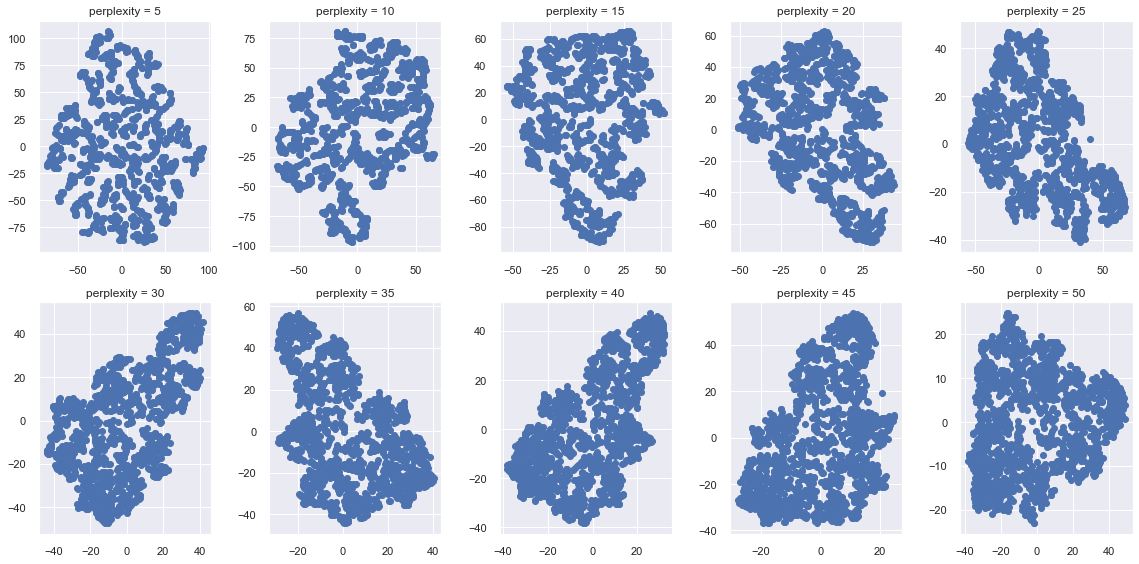

In [58]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, random_state=0)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [59]:
tsne = TSNE(perplexity=40, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

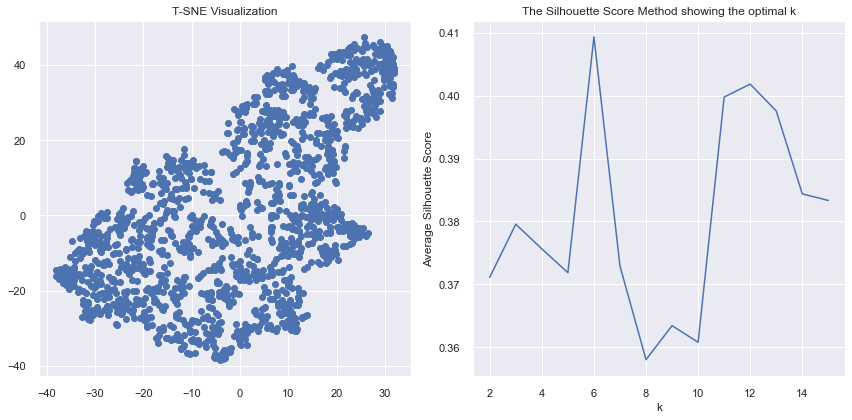

In [60]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [61]:
df_tsne = df.copy()
# Choose k = 6
sc_tsne = SpectralClustering(n_clusters=6, affinity='nearest_neighbors', random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

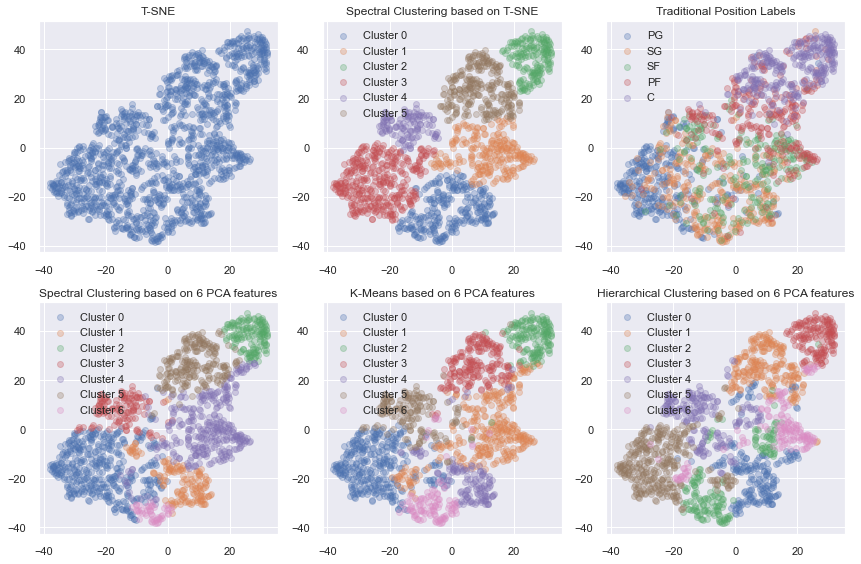

In [63]:
figsize(12, 8)

plt.subplot(2, 3, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE')

plt.subplot(2, 3, 2)
for i in range(6):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend()
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(2, 3, 3)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], X_tsne[pos_index, 1], label=pos, alpha=0.3)
plt.legend()
plt.title('Traditional Position Labels')

n_clusters = 7

plt.subplot(2, 3, 4)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend()
plt.title('Spectral Clustering based on 6 PCA features')


plt.subplot(2, 3, 5)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend()
plt.title('K-Means based on 6 PCA features')

plt.subplot(2, 3, 6)
agc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                              linkage='ward')
labels = agc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend()
plt.title('Hierarchical Clustering based on 6 PCA features')

plt.tight_layout()